## Building and Training the a CNN model for Image recognition on FPGAs using hls4ml

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = '/tools/Xilinx/Vivado/2020.1/bin:' + os.environ['PATH']



2025-04-04 23:59:34.910002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 23:59:34.979935: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 23:59:34.982137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-04 23:59:34.982144: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

/home/theodoros/Documents/AI_ON_FPGA/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-04 23:59:39.318806: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]2025-04-05 00:05:25.632380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-05 00:05:25.632420: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-05 00:05:25.632435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2025-04-05 00:05:25.632704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

Dataset svhn_cropped downloaded and prepared to /home/theodoros/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.
Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


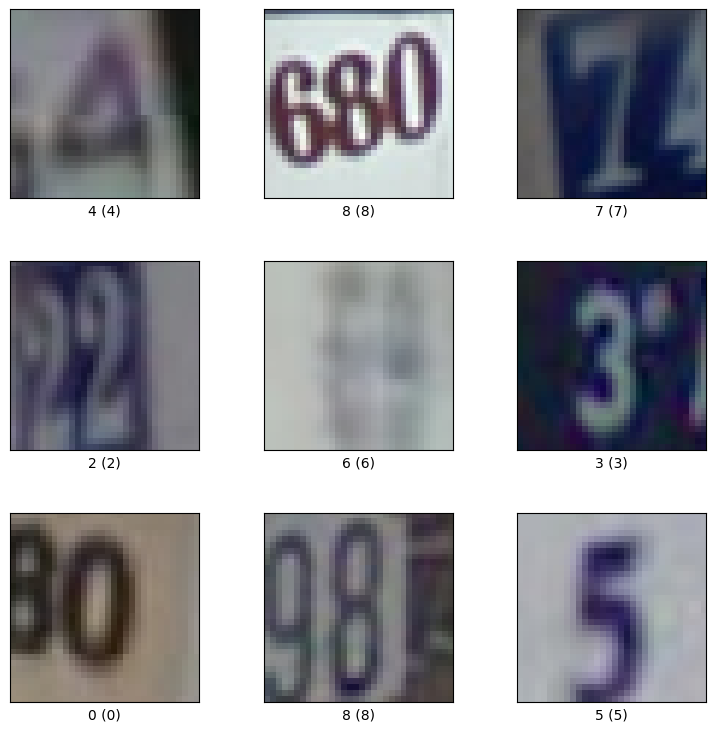

X train batch shape = (1024, 32, 32, 3), Y train batch shape = (1024, 10) 
X test batch shape = (26032, 32, 32, 3), Y test batch shape = (26032, 10) 


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

batch_size = 1024

train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test, nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

In [4]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 16)        432       
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 30, 30, 16)       64        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (N

In [14]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

fc1: 50176
Layer fc1 is too large (50176), are you sure you want to train?
output: 640


In [5]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Reshape y_train to have the correct shape
y_train = y_train.reshape(-1, num_classes)
# Reshape X_train to be 2D
X_train = X_train.reshape(-1, 28 * 28)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.2631 - accuracy: 0.9225 - val_loss: 0.1725 - val_accuracy: 0.9517
Epoch 2/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1126 - accuracy: 0.9665 - val_loss: 0.1471 - val_accuracy: 0.9599
Epoch 3/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0791 - accuracy: 0.9762 - val_loss: 0.1353 - val_accuracy: 0.9639
Epoch 4/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.1412 - val_accuracy: 0.9655
Epoch 5/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0438 - accuracy: 0.9864 - val_loss: 0.1529 - val_accuracy: 0.9655
Epoch 6/10
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.1598 - val_accuracy: 0.9688


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                50240     
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
 softmax (Activation)        (None, 10)                0         
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [8]:
import json
model_arch = json.loads(model.to_json())
for layer in model_arch['config']['layers']:
    if layer['class_name'] == 'InputLayer':
        print(json.dumps(layer, indent=2))


{
  "class_name": "InputLayer",
  "config": {
    "batch_input_shape": [
      null,
      784
    ],
    "dtype": "float32",
    "sparse": false,
    "ragged": false,
    "name": "fc1_input"
  }
}


In [9]:
# ------------------------------
# HLS4ML Conversion Section
# ------------------------------
# HLS4ML conversion
import hls4ml

import hls4ml

# Generate config with per-layer control
config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name',     # Enables 'LayerName' customization
)

# Global settings
config['Model']['Precision'] = 'ap_fixed<14,6>'
config['Model']['ReuseFactor'] = 56
config['Model']['Strategy'] = 'Resource'
config['Model']['IOType'] = 'io_stream'

# Layer-specific tuning
config['LayerName']['fc1']['ReuseFactor'] = 56
config['LayerName']['fc1']['Precision'] = 'ap_fixed<14,6>'

config['LayerName']['output']['ReuseFactor'] = 10
config['LayerName']['output']['Precision'] = 'ap_fixed<14,6>'

# Convert the model
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='hls4ml_prj_pynq',
    backend='VivadoAccelerator',     # Or 'Vitis' if doing full-on HLS synthesis
    board='pynq-z2'                   # Matches your target
)

# Optional: visualize
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True)



Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output shape: [None, 10]
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 784]], output shape: [None, 784]
Layer name: fc1, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 10]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 10]], output 

In [10]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
hls_model.compile()
X_test = X_test.reshape(-1, 28 * 28)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


438/438 [==============================] - 0s 756us/step
Keras  Accuracy: 0.9585714285714285
hls4ml Accuracy: 0.9580714285714286


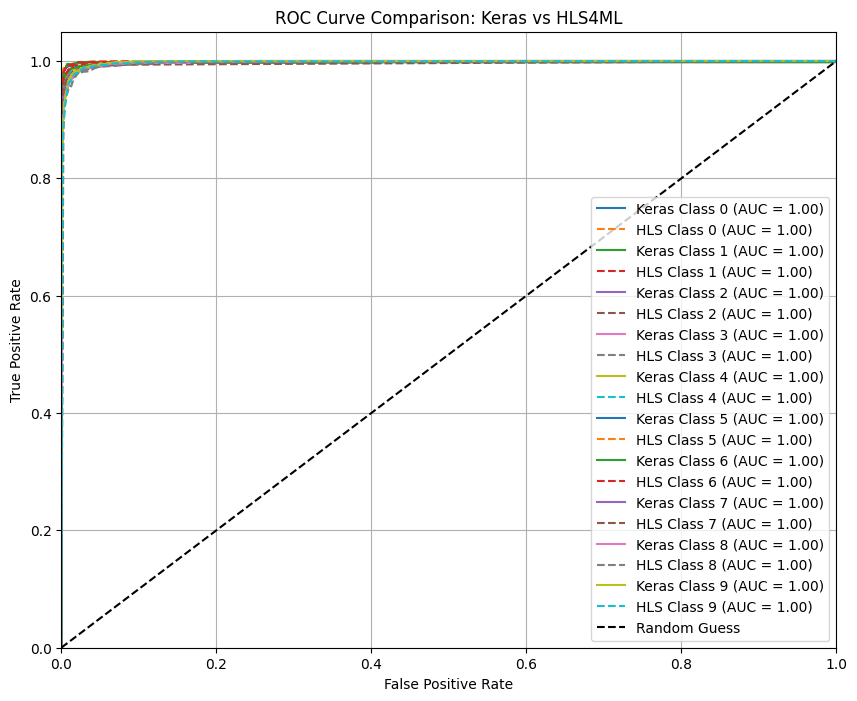

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Reshape the test data if necessary
X_test = X_test.reshape(-1, 28 * 28)

# Get predictions from both models
y_keras = model.predict(X_test)

# Compute accuracy for both models
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

# Compute ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr_keras, tpr_keras, roc_auc_keras = {}, {}, {}
fpr_hls, tpr_hls, roc_auc_hls = {}, {}, {}

for i in range(n_classes):
    fpr_keras[i], tpr_keras[i], _ = roc_curve(y_test[:, i], y_keras[:, i])
    roc_auc_keras[i] = auc(fpr_keras[i], tpr_keras[i])

    fpr_hls[i], tpr_hls[i], _ = roc_curve(y_test[:, i], y_hls[:, i])
    roc_auc_hls[i] = auc(fpr_hls[i], tpr_hls[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_keras[i], tpr_keras[i], label=f'Keras Class {i} (AUC = {roc_auc_keras[i]:.2f})')
    plt.plot(fpr_hls[i], tpr_hls[i], linestyle='--', label=f'HLS Class {i} (AUC = {roc_auc_hls[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Keras vs HLS4ML')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [13]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'theodoros' on host 'ubuntu' (Linux_x86_64 version 5.4.0-150-generic) on Fri Apr 04 23:38:33 PDT 2025
INFO: [HLS 200-10] On os Ubuntu 18.04.4 LTS
INFO: [HLS 200-10] In directory '/home/theodoros/Documents/AI_ON_FPGA/hls4ml_prj_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/theodoros/Documents/AI_ON_FPGA/hls4ml_prj_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INF

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.367',
  'BestLatency': '927',
  'WorstLatency': '929',
  'IntervalMin': '928',
  'IntervalMax': '930',
  'BRAM_18K': '382',
  'DSP': '986',
  'FF': '569939',
  'LUT': '215618',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')